In [1]:
!pip install pandas matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# dependencies block
import matplotlib.pyplot as plt
import json

In [3]:
# constants
COLOR_MAP = {
    "PageSize": "red",
    "CacheSize": "blue",
    "TlbSize": "green",
    "CacheAssociativity": "orange",
    "SinglePerformance": "purple"
}

BENCHMARK_NAMES = {
    0: "PageSize",
    1: "CacheSize",
    2: "TlbSize",
    3: "CacheAssociativity",
    4: "SinglePerformance"
}

FIGSIZE = (15, 10)
# loading data

def load_data(file_name):
    with open(file_name) as f:
        return json.load(f)

In [4]:
def plot_one_result(benchmark_data):
    fig, axs = plt.subplots(2, 3, figsize=FIGSIZE)

    for i, data_point in enumerate(benchmark_data):
        benchmark_type = BENCHMARK_NAMES[i]
        x_values = [point["x"] for point in data_point]
        y_values = [point["y"] for point in data_point]
    
        row = i // 3
        col = i % 3
    
        axs[row, col].scatter(x_values, y_values, color=COLOR_MAP[benchmark_type], label=benchmark_type)
        axs[row, col].set_xlabel("size")
        axs[row, col].set_ylabel("clock")
        axs[row, col].set_title(benchmark_type)

    plt.show()

def plot_two_results(data1, data2):
    fig, axs = plt.subplots(2, 3, figsize=FIGSIZE)
        
    for i, (benchmark_data1, benchmark_data2) in enumerate(zip(data1, data2)):
        benchmark_type = BENCHMARK_NAMES[i]
        x_values1 = [point["x"] for point in benchmark_data1]
        y_values1 = [point["y"] for point in benchmark_data1]
        x_values2 = [point["x"] for point in benchmark_data2]
        y_values2 = [point["y"] for point in benchmark_data2]
    
        row = i // 3
        col = i % 3
        
        axs[row, col].scatter(x_values1, y_values1, color=COLOR_MAP[benchmark_type], label="Results")
        axs[row, col].scatter(x_values2, y_values2, color="black", marker="x", label="Optimized Results")
        axs[row, col].set_xlabel("size")
        axs[row, col].set_ylabel("clock")
        axs[row, col].set_title(benchmark_type)
        axs[row, col].legend()

    plt.show()

# Plot two sets of benchmark data side by side
def plot_benchmark_data_comparison(rust_data, native_data):
    def plot_comparison(axs, rust_data, native_data, benchmark_type):
        x_values1 = [point["x"] for point in rust_data]
        y_values1 = [point["y"] for point in rust_data]
        x_values2 = [point["x"] for point in native_data]
        y_values2 = [point["y"] for point in native_data]

        axs.scatter(x_values1, y_values1, color=COLOR_MAP[benchmark_type], label="Rust Results")
        axs.scatter(x_values2, y_values2, color="black", marker="x", label="Native Results")
        axs.set_xlabel("size")
        axs.set_ylabel("clock")
        axs.set_title(benchmark_type)
        axs.legend()

    fig, axs = plt.subplots(2, 3, figsize=FIGSIZE)

    for i, (rust_data_point, native_data_point) in enumerate(zip(rust_data, native_data)):
        benchmark_type = BENCHMARK_NAMES[i]
        row = i // 3
        col = i % 3
        plot_comparison(axs[row, col], rust_data_point, native_data_point, benchmark_type)

    plt.show()
    
    
def map_old_impl_data(old_data):
    page_size = old_data[0]
    cache_size = old_data[3] + old_data[4]
    tlb_size = old_data[5]
    cache_assoc = old_data[2]
    single_perf = old_data[10]

    return [page_size, cache_size, tlb_size, cache_assoc, single_perf]

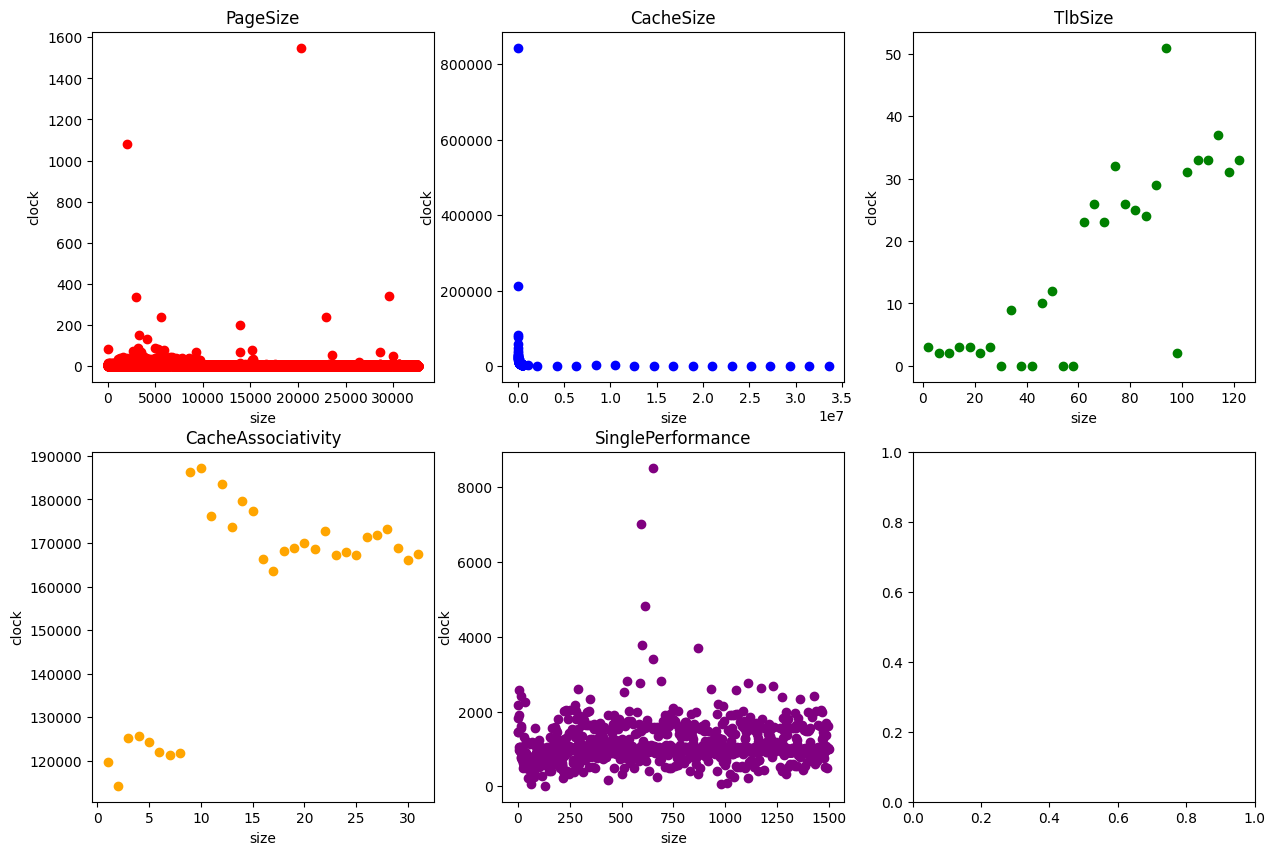

In [5]:
# some filename conventions to avoid confusion:
# results.json are results from our rust implementation
# optimized_results.json are results from our rust implementation, but with the optimization arguments enabled
# old_results.json are results from their Django + Javascript + WASM implementation

# this way we can visualize the results from one run of the in-browser benchmarks

plot_one_result(load_data('results.json'))

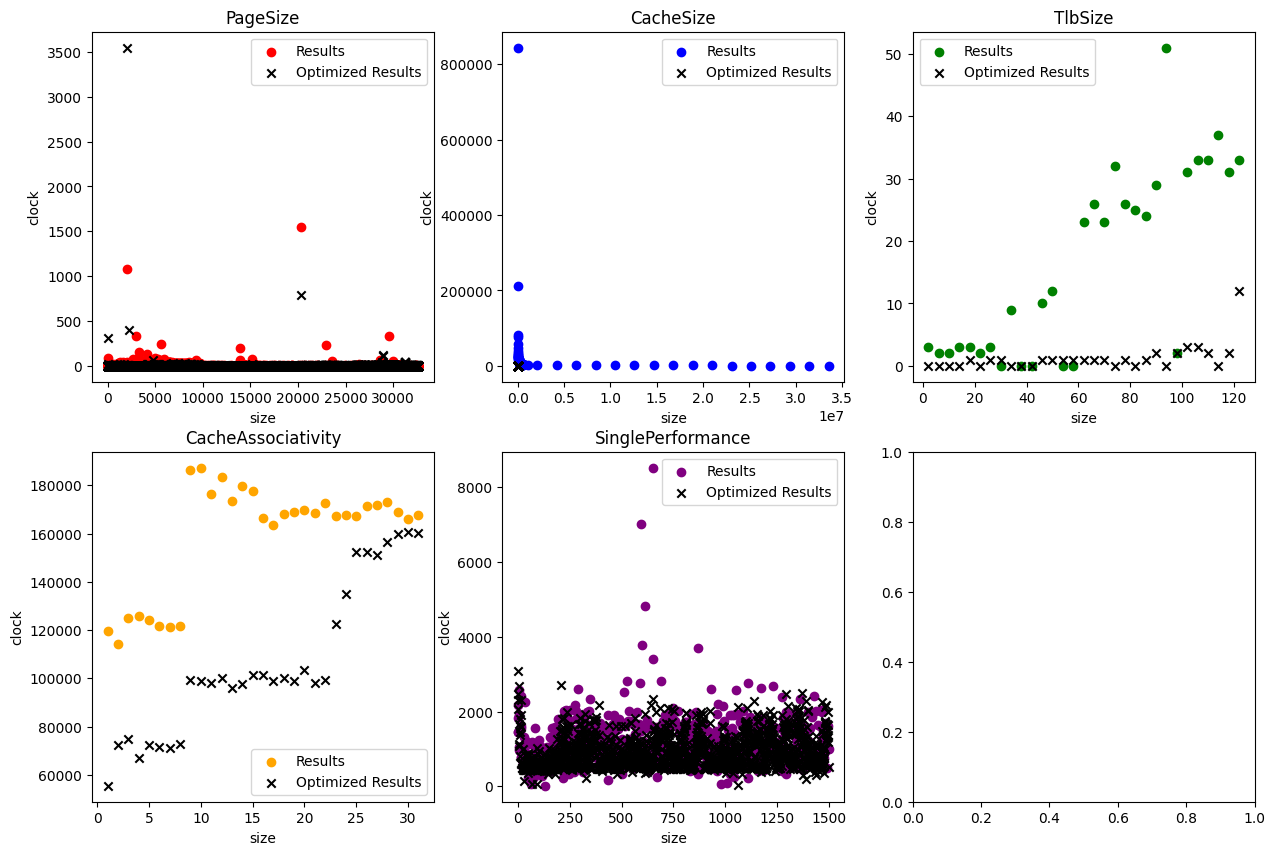

In [6]:
# this allows comparing two different runs and comparing the difference between the two

plot_two_results(load_data('results.json'), load_data('optimized_results.json'))

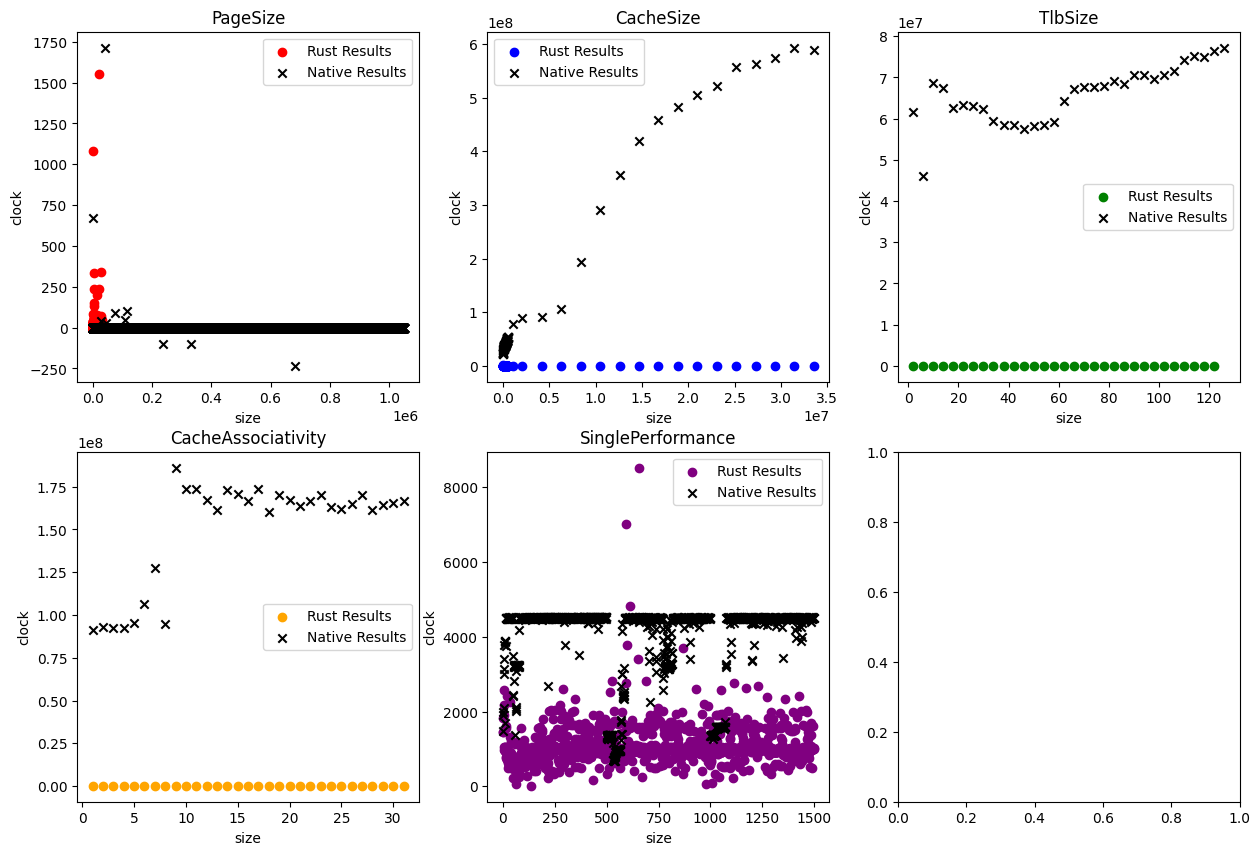

In [7]:
# it seems that the original benchmark implementation dump contains the following data at the following index:
#
# 0 - pagesize
# 1 - prefetcher
# 2 - cache associativity
# 3 - cache size (upto 512 kb)
# 4 - cache size (512 kb +)
# 5 - tlb size
# 6 - timer precision over time
# 7 - timer increments per clock edge
# 8 - memory latencies
# 9 - load buffer size
# 10 - single core perf
# 11 - multi core perf
# 12 - number of cores

# our benchmarks result data layout can be seen in BENCHMARK_NAMES
# this means that from the old implementation, the following data mapping is required
# 0 -> 0
# 3/4 -> 1
# 5 -> 2
# 2 -> 3
# 10 -> 4


current_implementation_results = load_data("results.json")
old_implementation_results = map_old_impl_data(load_data("old_results.json"))

plot_benchmark_data_comparison(current_implementation_results, old_implementation_results)

# The resulting plots show that the data indices and y-ranges are misaligned between the two datasets
# Aligning will require some extra work
